Copyright 2021 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This solution, including any related sample code or data, is made available 
on an “as is,” “as available,” and “with all faults” basis, solely for 
illustrative purposes, and without warranty or representation of any kind. 
This solution is experimental, unsupported and provided solely for your 
convenience. Your use of it is subject to your agreements with Google, as 
applicable, and may constitute a beta feature as defined under those 
agreements.  To the extent that you make any data available to Google in 
connection with your use of the solution, you represent and warrant that you 
have all necessary and appropriate rights, consents and permissions to permit 
Google to use and process that data.  By using any portion of this solution, 
you acknowledge, assume and accept all risks, known and unknown, associated 
with its usage, including with respect to your deployment of any portion of 
this solution in your systems, or usage in connection with your business, 
if at all.


### Additional Resources:


*   [PyMC3 Documentation](https://docs.pymc.io/) 
*   [Github](https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb)
*   [Github](https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Demonstration.ipynb)


# Setup

### Load modules

In [1]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

!pip install fitter
import fitter
from fitter import Fitter, get_common_distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.2
     |████████████████████████████████| 55 kB 3.0 MB/s 
  Created wheel for fitter: filename=fitter-1.3.0-py3-none-any.whl size=24761 sha256=a6cf669dd8172683120af41efd253c1fcee801e1b6db31040ab6f51be8d2e704
  Stored in directory: /root/.cache/pip/wheels/b3/fb/07/86487066f9376e93b115a54f6f8299d7609fc623ef912a6f5a
  Created wheel for easydev: filename=easydev-0.11.1-py3-none-any.whl size=64268 sha256=c81954b12f4a7817c27b67096a6d7d2ccb818f7bde46ea21a9168ac1076118c4
  Stored in directory: /root/.cache/pip/wheels/56/fc/6d/9d9b5562f4fc029cbe483d577d3110d274a82116fee348af10
Successfully built fitter easydev


# Define Parameters

In [2]:
#@title Parameters

INPUT_SHEET_NAME = 'model input data 8.17.21' #@param {type:"string"}


### Load model input data

In [3]:
google_sheets_name = INPUT_SHEET_NAME #@param

In [4]:
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

In [5]:
'''
%%bigquery df
SELECT *
FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`
WHERE Division IS NOT NULL;
'''

'\n%%bigquery df\nSELECT *\nFROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`\nWHERE Division IS NOT NULL;\n'

In [6]:
df = df[['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts']]

In [7]:
#df.fillna(mean, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Brand_x_Core_x_NC_clicks             607 non-null    float64
 1   The_Trade_Desk_x_Audio_x_AWA_imps    607 non-null    float64
 2   DBM_x_Display_x_RTG_imps             607 non-null    float64
 3   Amazon_x_Display_x_AWA_imps          607 non-null    float64
 4   DBM_x_Video_x_AWA_imps               607 non-null    float64
 5   The_Trade_Desk_x_Display_x_AWA_imps  607 non-null    float64
 6   Brand_x_RMKT_x_EC_clicks             607 non-null    float64
 7   OTHER_x_Display_x_AWA_imps           607 non-null    float64
 8   Amazon_x_Display_x_RTG_imps          607 non-null    float64
 9   DBM_x_Display_x_ACQ_imps             607 non-null    float64
 10  Oath_x_Display_x_AWA_imps            607 non-null    float64
 11  DBM_x_Display_x_AWA_imps        

In [9]:
df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
0,1.17396,0.85686,0.53833,0.13739,2.42995,0.13442,-0.17394,0.15935,2.03978,3.02039,0.14012,2.38000,1653
1,-0.36973,0.38510,-0.24605,0.83248,-0.33732,0.13442,-0.93820,1.41059,0.66279,0.17586,0.14012,0.45270,1466
2,-2.47505,-0.21720,-0.06182,0.61213,-0.89596,0.13442,-1.48463,1.30628,0.96433,0.26480,0.14012,-0.17511,604
3,-1.60225,0.46500,0.38572,1.57292,-0.29257,0.13442,-1.28564,1.83450,1.54080,0.14549,0.14012,0.56023,891
4,-0.64928,0.74772,-0.06955,0.15105,2.07830,0.13442,-0.75104,-0.96072,-2.09731,2.31277,0.14012,1.63565,1023


In [10]:
KPI_COL = "new_accounts" #@param {type: "string"}

In [11]:
y = df[KPI_COL]
x = df[df.columns[df.columns != KPI_COL]]

In [12]:
x.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps'],
      dtype='object', name=0)

In [13]:
len(x.columns)

12

## Bayesian Model

In [14]:
with pm.Model() as linear_model:

    ## OPTION 1: Set all priors to same GLM family

    '''
    formula = 'y ~ x'

    family = pm.glm.families.Poisson() 
  
    pm.GLM.from_formula(formula = formula, family = family, data = data)
    '''


    ## OPTION 2: Set prior distributions individually

    
    #This code sets flat priors by default, but it is recommended to create more informative priors depending on use case

    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 100)
    
    # Beta parameters
      # Use this loop if you want to set all coefficients to the same prior distribution
      # This loop allows you to set prior distributions outside of the GLM options above
    for z in range(1, len(x.columns)+1):
      locals()['beta%s' % z] = pm.Flat('beta%s' % z)
    
    # Or set individual priors
    #beta1 = pm.Uniform('beta1')


    # Standard deviation
      #Can only be positive, thus has to take on a halfnormal dist.
    sigma = pm.HalfNormal('sigma', sd = 10) 



    ## SET UP FORMULA TO ESTIMATE 
    # Estimate of mean
    mean = intercept + (beta1 *x['Brand_x_Core_x_NC_clicks']) + (beta2 *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (beta3 *x['DBM_x_Display_x_RTG_imps']) + (beta4 *x['Amazon_x_Display_x_AWA_imps']) + (beta5 *x['DBM_x_Video_x_AWA_imps']) + (beta6 *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (beta7 *x['Brand_x_RMKT_x_EC_clicks']) + (beta8 *x['OTHER_x_Display_x_AWA_imps']) + (beta9 *x['Amazon_x_Display_x_RTG_imps']) + (beta10 *x['DBM_x_Display_x_ACQ_imps']) + (beta11 *x['Oath_x_Display_x_AWA_imps']) + (beta12 *x['DBM_x_Display_x_AWA_imps']) 


    ## SPECIFY LIKELIHOOD
    likelihood = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    

    # SAMPLE FROM THE POSTERIOR DISTRIBUTION
    normal_trace = pm.sample()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.
The acceptance probability does not match the target. It is 0.9422909194877956, but should be close to 0.8. Try to increase the number of tuning steps.


#### Results

Print parameter names

In [15]:
normal_trace.varnames

['Intercept',
 'beta1',
 'beta2',
 'beta3',
 'beta4',
 'beta5',
 'beta6',
 'beta7',
 'beta8',
 'beta9',
 'beta10',
 'beta11',
 'beta12',
 'sigma_log__',
 'sigma']

Print estimates

In [16]:
print(pm.summary(normal_trace).round(3))

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
Intercept 1491.76200 7.69800  1476.55400 1505.83100 0.13200    0.09300    
beta1     357.07500  10.58200 339.03000  378.41000  0.28100    0.19900    
beta2     -132.54600 11.33200 -153.14600 -110.48700 0.28700    0.20300    
beta3     48.42700   9.07700  32.21000   66.40100   0.20600    0.15000    
beta4     33.93900   8.81700  17.70000   50.26000   0.17200    0.12500    
beta5     47.25400   9.73200  29.26300   65.22500   0.19000    0.13400    
beta6     52.82700   8.29600  36.82900   68.13100   0.16200    0.11500    
beta7     -124.37900 15.18700 -153.47900 -97.09900  0.44700    0.31600    
beta8     -72.88900  11.50800 -94.39000  -50.91800  0.26400    0.18800    
beta9     -31.64900  9.20800  -50.04100  -15.39500  0.18100    0.13100    
beta10    113.30000  14.47800 86.51200   141.24400  0.30800    0.22100    
beta11    34.26700   7.86300  19.60100   49.30400   0.14500    0.10400    
beta12    -139.99900 15.7

In [17]:
pm.summary(normal_trace).round(3)['mean']

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Intercept   1491.76200
beta1       357.07500 
beta2       -132.54600
beta3       48.42700  
beta4       33.93900  
beta5       47.25400  
beta6       52.82700  
beta7       -124.37900
beta8       -72.88900 
beta9       -31.64900 
beta10      113.30000 
beta11      34.26700  
beta12      -139.99900
sigma       191.21100 
Name: mean, dtype: float64

#### Visualize model results

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d73e1bb90>,
      dtype=object)

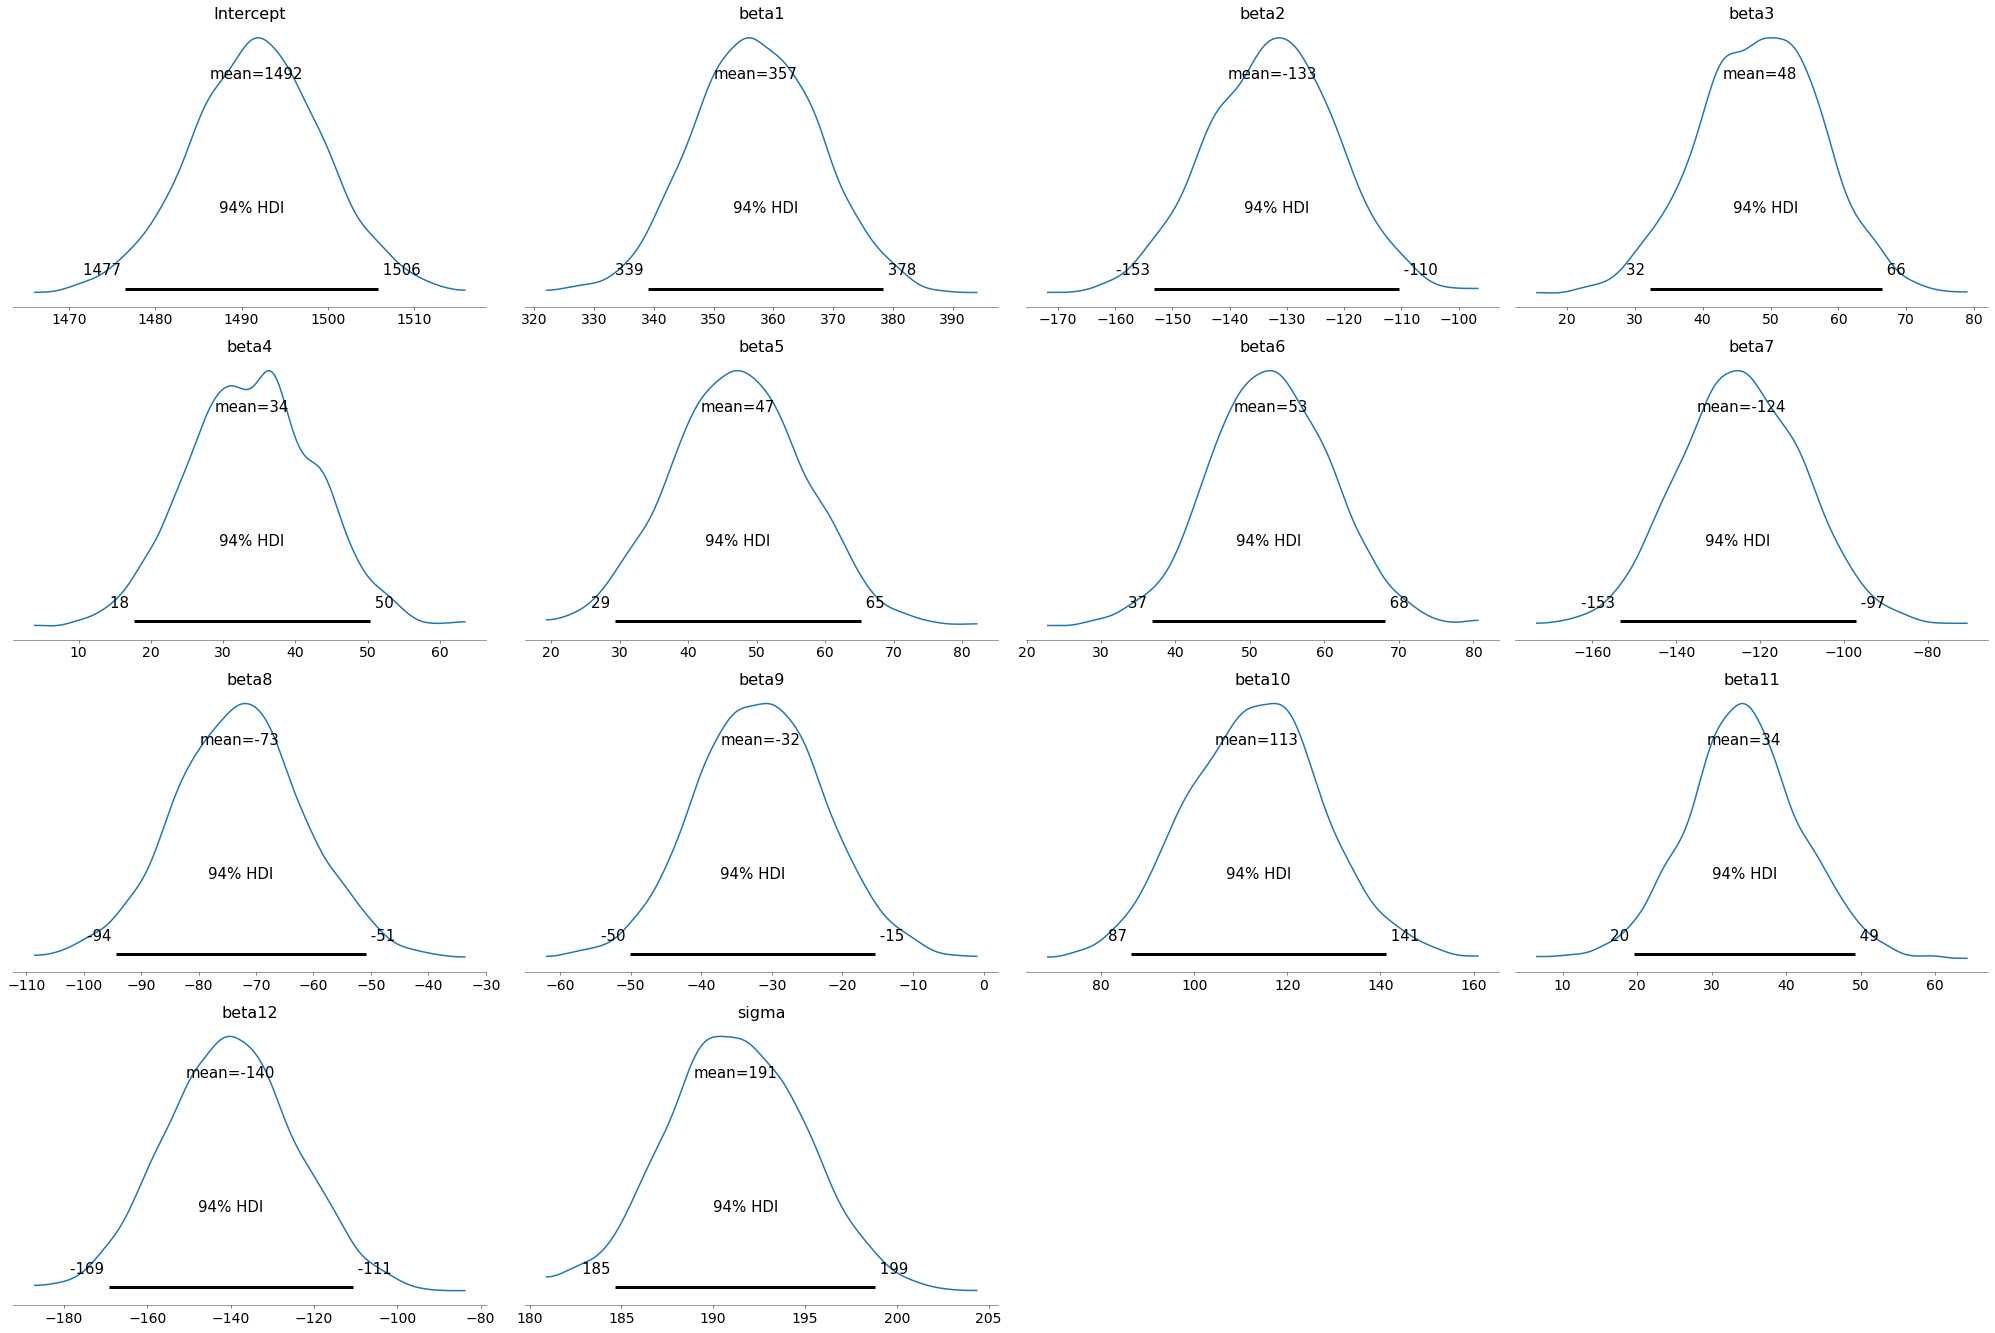

In [18]:
az.plot_posterior(normal_trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

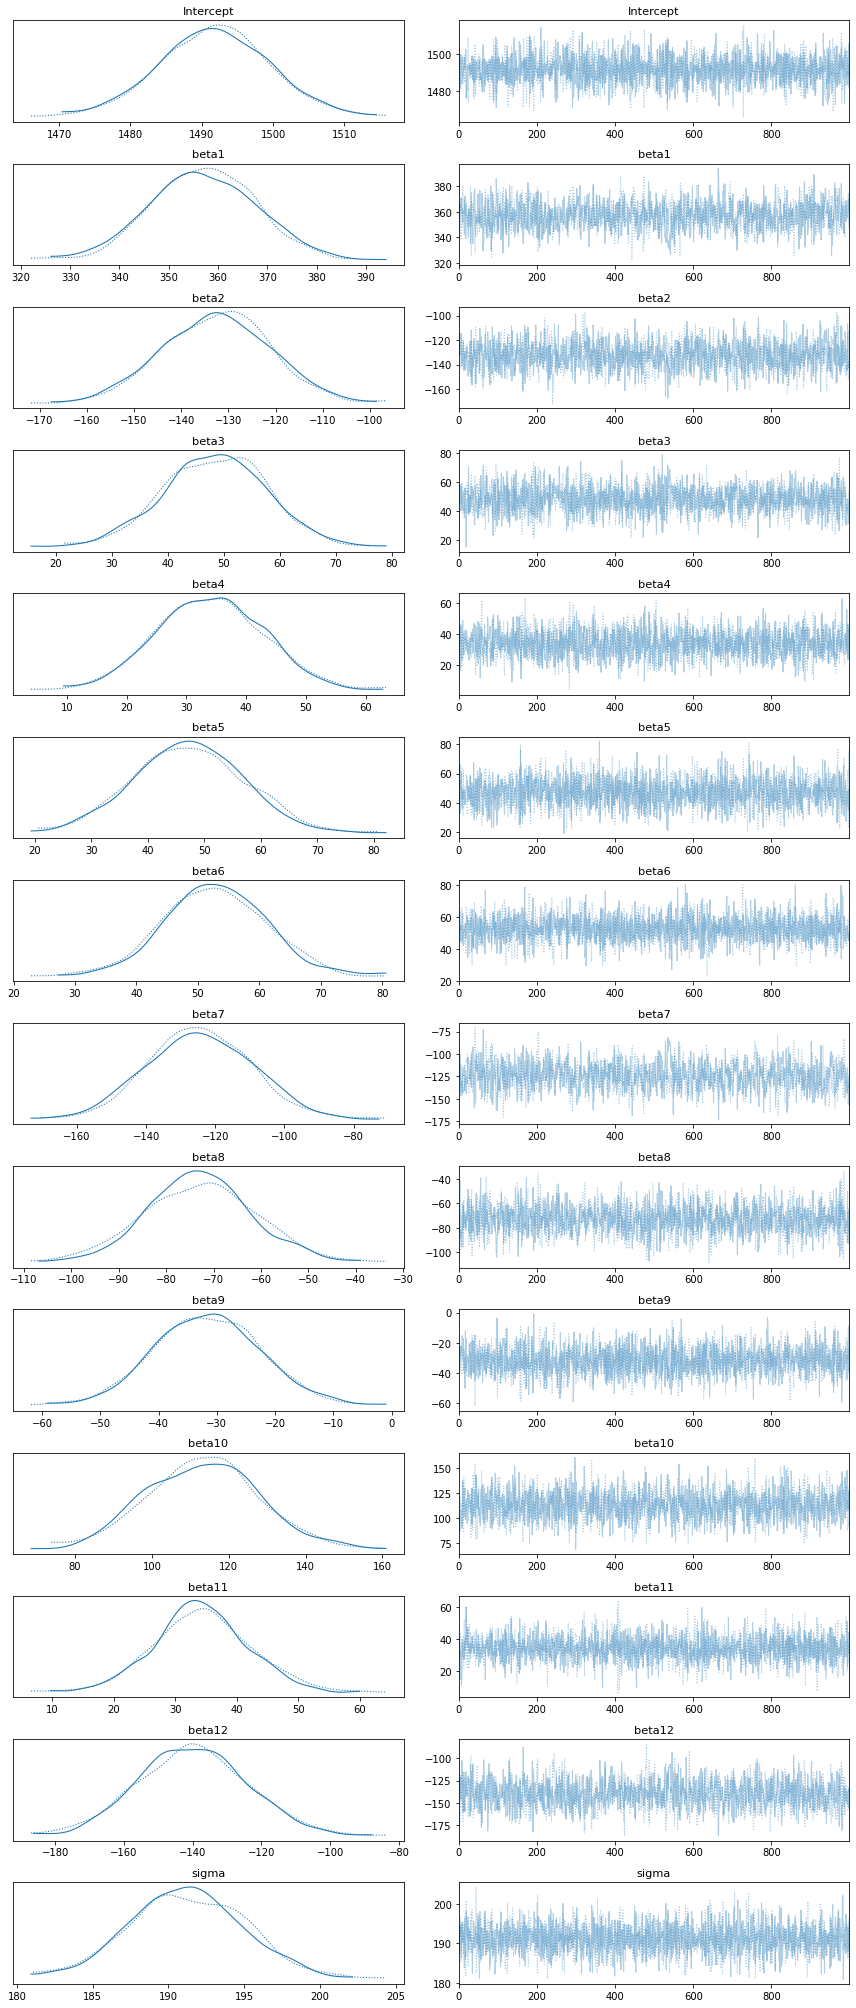

In [19]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d80453b10>],
      dtype=object)

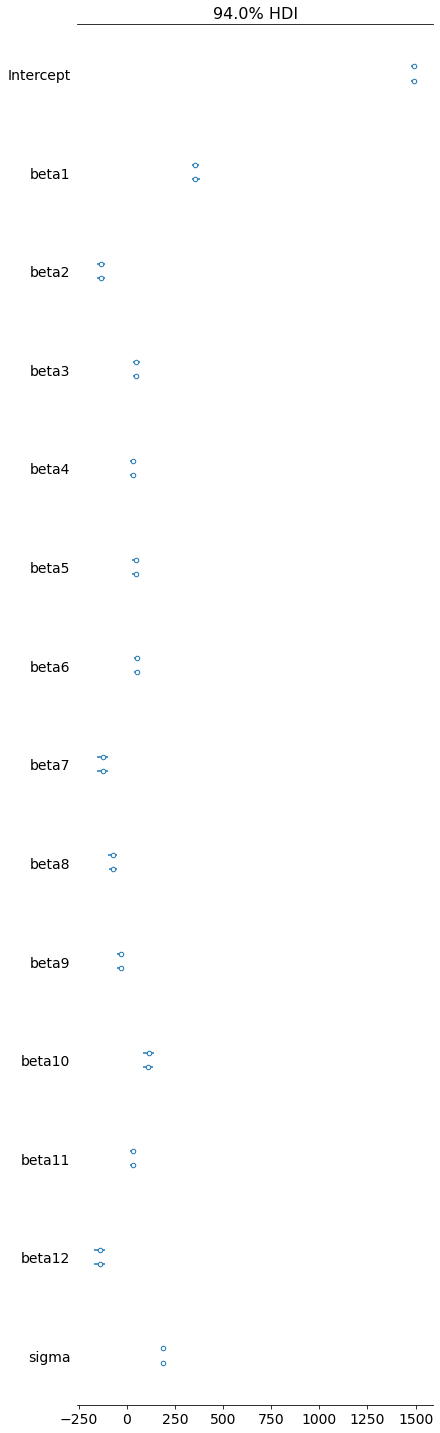

In [20]:
pm.forestplot(normal_trace)

#### Predictions

In [21]:
normal_trace.varnames

['Intercept',
 'beta1',
 'beta2',
 'beta3',
 'beta4',
 'beta5',
 'beta6',
 'beta7',
 'beta8',
 'beta9',
 'beta10',
 'beta11',
 'beta12',
 'sigma_log__',
 'sigma']

Obtain the average parameter estimates

In [22]:
var_dict = {}
for variable in normal_trace.varnames:
  var_dict[variable] = normal_trace[variable]
  
# Results into a dataframe
var_weights = pd.DataFrame(var_dict)
var_weights = var_weights.drop(columns = ['sigma_log__','sigma'])
  
# Means for all the weights
var_means = var_weights.mean(axis=0)

In [23]:
var_means

Intercept   1491.76210
beta1       357.07478 
beta2       -132.54636
beta3       48.42655  
beta4       33.93907  
beta5       47.25391  
beta6       52.82725  
beta7       -124.37949
beta8       -72.88908 
beta9       -31.64922 
beta10      113.30037 
beta11      34.26706  
beta12      -139.99886
dtype: float64

In [24]:
x['Intercept'] = 1

Create predictions using the average parameter estimates

In [25]:
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['Brand_x_Core_x_NC_clicks']) + (var_means['beta2'] *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (var_means['beta3'] *x['DBM_x_Display_x_RTG_imps']) + (var_means['beta4'] *x['Amazon_x_Display_x_AWA_imps']) + (var_means['beta5'] *x['DBM_x_Video_x_AWA_imps']) + (var_means['beta6'] *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (var_means['beta7'] *x['Brand_x_RMKT_x_EC_clicks']) + (var_means['beta8'] *x['OTHER_x_Display_x_AWA_imps']) + (var_means['beta9'] *x['Amazon_x_Display_x_RTG_imps']) + (var_means['beta10'] *x['DBM_x_Display_x_ACQ_imps']) + (var_means['beta11'] *x['Oath_x_Display_x_AWA_imps']) + (var_means['beta12'] *x['DBM_x_Display_x_AWA_imps']) 


In [26]:
residuals = Y_pred - y

#### Evaluation Metrics

In [27]:
mean_absolute_error(y,Y_pred)

189.24584914448172

In [28]:
mean_squared_error(y,Y_pred)

57684.65576328705

In [29]:
rmse = np.sqrt(mean_squared_error(y,Y_pred))
rmse

240.1763014189515

In [30]:
r2_score(y, Y_pred)[0]

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py (507)

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 507:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 508:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in data:


0.726574226033688

### Cross-Validation

#### Leave One Out

In [31]:
loo = LeaveOneOut()

In [32]:
# initiate list for loop to aggregate metric results

X_array = np.array(x) 
Y_array = np.array(y)

Y_true = []
Y_hat = []
for train_idx, test_idx in loo.split(x):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    Y_train, Y_test = Y_array[train_idx], Y_array[test_idx]

    Y_pred = (var_means['Intercept']*X_test[:,10]) + (var_means['beta1']*X_test[:,0]) + (var_means['beta2']*X_test[:,1]) + (var_means['beta3']*X_test[:,2]) + (var_means['beta4']*X_test[:,3]) + (var_means['beta5']*X_test[:,4]) + (var_means['beta6']*X_test[:,5])  + (var_means['beta7']*X_test[:,6]) + (var_means['beta8']*X_test[:,7]) + (var_means['beta9']*X_test[:,8])+ (var_means['beta10']*X_test[:,9])
    Y_true += list(Y_test)
    Y_hat += list(Y_pred)

r2_loo = r2_score(np.array(Y_true), np.array(Y_hat))

In [33]:
errors = Y_pred - Y_test
mae_loo = np.mean(abs(errors))
mse_loo = np.mean(errors ** 2)
rmse_loo = np.sqrt(np.mean(errors ** 2))


####Leave P Out

In [34]:
#@title Input P for hold-out size (for model cross validation using leave-P-out)
P_HOLD_OUT = 2 #@param {type: "integer"}

In [35]:
# model cross validation using leave-P-out (specify P as hold-out size)
lpo = LeavePOut(p=P_HOLD_OUT)

In [36]:
for train_idx, test_idx in lpo.split(x):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    Y_train, Y_test = Y_array[train_idx], Y_array[test_idx]

    Y_pred = (var_means['Intercept']*X_test[:,10]) + (var_means['beta1']*X_test[:,0]) + (var_means['beta2']*X_test[:,1]) + (var_means['beta3']*X_test[:,2]) + (var_means['beta4']*X_test[:,3]) + (var_means['beta5']*X_test[:,4]) + (var_means['beta6']*X_test[:,5])  + (var_means['beta7']*X_test[:,6]) + (var_means['beta8']*X_test[:,7]) + (var_means['beta9']*X_test[:,8])+ (var_means['beta10']*X_test[:,9])
    Y_true += list(Y_test)
    Y_hat += list(Y_pred)

r2_lpo = r2_score(np.array(Y_true), np.array(Y_hat))

In [37]:
errors = Y_pred - Y_test
mae_lpo = np.mean(abs(errors))
mse_lpo = np.mean(errors ** 2)
rmse_lpo = np.sqrt(np.mean(errors ** 2))


#### Evaluation

In [38]:
cv_df = pd.DataFrame(columns=('CV Method','MAE','R2', 'MSE', 'RMSE')) 
cv_df.loc[len(cv_df)] = ['LOO',mae_loo, r2_loo[0], mse_loo, rmse_loo]
cv_df.loc[len(cv_df)] = ['LPO',mae_lpo,r2_lpo[0], mse_lpo, rmse_lpo]
cv_df

,CV Method,MAE,R2,MSE,RMSE
0,LOO,836.33437,0.52270,699455.17207,836.33437
1,LPO,1238.14891,0.52270,1694467.64815,1301.71719


# Validate Linear Regression Model Assumptions

####1. Linearity

Visually inspect linearity between target variable and predictions

In [39]:
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['Brand_x_Core_x_NC_clicks']) + (var_means['beta2'] *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (var_means['beta3'] *x['DBM_x_Display_x_RTG_imps']) + (var_means['beta4'] *x['Amazon_x_Display_x_AWA_imps']) + (var_means['beta5'] *x['DBM_x_Video_x_AWA_imps']) + (var_means['beta6'] *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (var_means['beta7'] *x['Brand_x_RMKT_x_EC_clicks']) + (var_means['beta8'] *x['OTHER_x_Display_x_AWA_imps']) + (var_means['beta9'] *x['Amazon_x_Display_x_RTG_imps']) + (var_means['beta10'] *x['DBM_x_Display_x_ACQ_imps']) + (var_means['beta11'] *x['Oath_x_Display_x_AWA_imps']) + (var_means['beta12'] *x['DBM_x_Display_x_AWA_imps']) 


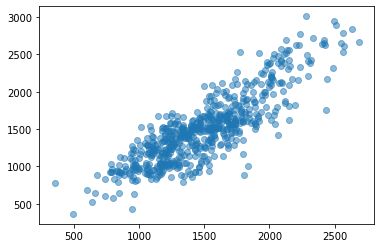

In [40]:
plt.plot(Y_pred,y,'o',alpha=0.5)
plt.show()

#### 2. Normality of Errors

Visually inspect the residuals to confirm normality

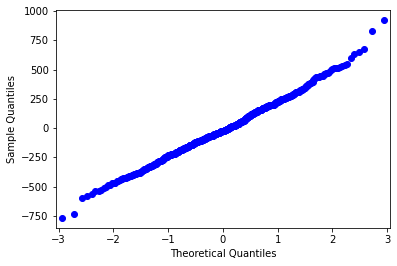

In [41]:
fig = sm.qqplot(residuals)

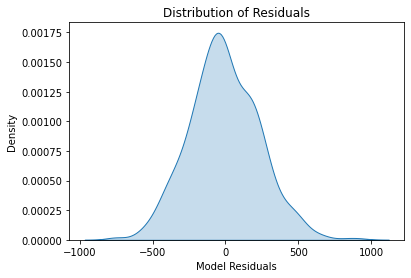

In [42]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

####3. Absence of Multicollinearity

Tested and checked during data processing stage

####4. Homoscedasticity


Visually inspect residuals to confirm constant variance

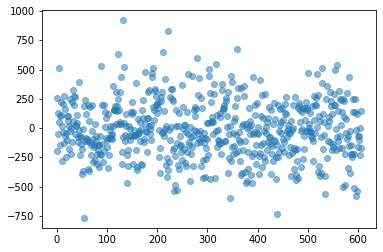

In [43]:
plt.plot(residuals,'o',alpha=0.5)
plt.show()

# Appendix

## Parameterization Help

Use the `fitter` package to auto-detect the probability distribution of your data

In [45]:
'''
sns.kdeplot(x[x.columns[3]], label = '', shade = True)
plt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');

f = Fitter(x[x.columns[2]],
           distributions= get_common_distributions())
f.fit()
f.summary()

f.get_best(method = 'aic')
f.fitted_param['uniform']
'''

"\nsns.kdeplot(x[x.columns[3]], label = '', shade = True)\nplt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');\n\nf = Fitter(x[x.columns[2]],\n           distributions= get_common_distributions())\nf.fit()\nf.summary()\n\nf.get_best(method = 'aic')\nf.fitted_param['uniform']\n"